In [1]:
#Importing necessary modules
import os
import pickle
import glob
import cv2

import matplotlib.pyplot as plt
import numpy as np
from numpy import expand_dims
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential, save_model, load_model, Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing import image

In [2]:
# This is required when using GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

In [3]:
# Fixed, no need change
def load_data(file):
    with open(file, 'rb') as fo:
        try:
            samples = pickle.load(fo)
        except UnicodeDecodeError:  # python 3.x
            fo.seek(0)
            samples = pickle.load(fo, encoding='latin1')

    data, labels = samples['data'], samples['labels']

    data = np.array(data, dtype=np.float32) / 255
    labels = np.array(labels, dtype=np.int32)
    return data, labels


In [4]:
def CNNmodel(num_ch_c1, num_ch_c2, use_dropout):
    #Model for CNN
    model = tf.keras.Sequential()
    model.add(layers.Input(shape=(3072, )))
    model.add(layers.Reshape(target_shape=(32, 32, 3), input_shape=(3072,)))
    #A convolution  layer 𝐶1 with 50 channels,window  size  9x9,  VALID  padding,  and  ReLU activation
    model.add(layers.Conv2D(num_ch_c1, 9, activation='relu', input_shape=(None, None, 3)))
    #A max pooling layer 𝑆1 with a pooling window of size 2x2, stride = 2,and VALID padding
    model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid'))
    #A  convolution  layer 𝐶2 with 60 channels, window  size  5x5,  VALID  padding,  and  ReLU activation
    model.add(layers.Conv2D(num_ch_c2, 5, activation='relu', input_shape=(None, None, 3)))
    #A max pooling layer 𝑆2 with a pooling window of size 2x2, stride = 2,and VALID padding
    model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid'))
    #A fully-connected layer 𝐹1 of size 300 with no activation
    model.add(layers.Dense(300))
    model.add(layers.Flatten())
    #A fully-connected layer 𝐹2 of size 10 with Softmax activation
    model.add(layers.Dense(10, use_bias=True, input_shape=(300,),activation='softmax'))  # Softmax
    return model

In [5]:
def main():
    seed = 0
    np.random.seed(seed)
    tf.random.set_seed(seed)

    num_ch_c1 = 50  # Question 2
    num_ch_c2 = 60  # Question 2

    epochs = 1000  # Fixed
    batch_size = 128  # Fixed
    learning_rate = 0.001
    optimizer_ = 'SGD'  # Question 3
    use_dropout = False  # Question 3(d) (see make_model)

    #model = make_model(num_ch_c1, num_ch_c2, use_dropout)
    model = CNNmodel(num_ch_c1, num_ch_c2, use_dropout)
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

    if optimizer_ == 'SGD':
        optimizer = keras.optimizers.SGD(learning_rate=learning_rate)
    elif optimizer_ == 'SGD-momentum':  # Question 3(a)
        raise NotImplementedError('Complete it by yourself')
    elif optimizer_ == 'RMSProp':  # Question 3(b)
        raise NotImplementedError('Complete it by yourself')
    elif optimizer_ == 'Adam':  # Question 3(c)
        raise NotImplementedError('Complete it by yourself')
    else:
        raise NotImplementedError(f'You do not need to handle [{optimizer_}] in this project.')

    # Training and test
    x_train, y_train = load_data('data_batch_1')
    x_test, y_test = load_data('test_batch_trim')

    # Training
    model.compile(optimizer=optimizer, loss=loss, metrics='accuracy')
    history = model.fit(
        x_train,
        y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(x_test, y_test))

    ''' Fill in Question 1(b) here. This website may help:
            https://towardsdatascience.com/visualizing-intermediate-activation-in-convolutional-neural-networks-with-keras-260b36d60d0
    '''
    


    # Create folder to store models and results
    if not os.path.exists('./models'):
        os.mkdir('./models')
    if not os.path.exists('./results'):
        os.mkdir('./results')

    # Save model
    if use_dropout:
        model.save(f'./models/{num_ch_c1}_{num_ch_c2}_{optimizer_}_dropout')
    else:
        model.save(f'./models/{num_ch_c1}_{num_ch_c2}_{optimizer_}_no_dropout')

    #Save History
    if not os.path.exists('./trainHistory'):
        os.mkdir('./trainHistory')
    #Save History
    with open('./trainHistory/trainHistoryDict.json', 'wb') as file_pi:
        pickle.dump(history.history, file_pi)

    # Save the plot for losses
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    plt.plot(range(1, len(train_loss) + 1), train_loss, label='Train')
    plt.plot(range(1, len(val_loss) + 1), val_loss, label='Test')
    plt.title('Model Loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend()
    if use_dropout:
        plt.savefig(
            f'./results/{num_ch_c1}_{num_ch_c2}_{optimizer_}_dropout_loss.pdf')
    else:
        plt.savefig(
            f'./results/{num_ch_c1}_{num_ch_c2}_{optimizer_}_no_dropout_loss.pdf'
        )
    plt.close()

    # Save the plot for accuracies
    train_acc = history.history['accuracy']
    test_acc = history.history['val_accuracy']
    plt.plot(range(1, len(train_acc) + 1), train_acc, label='Train')
    plt.plot(range(1, len(test_acc) + 1), test_acc, label='Test')
    plt.title('Model Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend()
    if use_dropout:
        plt.savefig(
            f'./results/{num_ch_c1}_{num_ch_c2}_{optimizer_}_dropout_accuracy.pdf'
        )
    else:
        plt.savefig(
            f'./results/{num_ch_c1}_{num_ch_c2}_{optimizer_}_no_dropout_accuracy.pdf'
        )
    plt.close()

In [6]:
if __name__ == '__main__':
    main()

79 [==============================] - 10s 133ms/step - loss: 2.1210 - accuracy: 0.3393 - val_loss: 2.1230 - val_accuracy: 0.3295
Epoch 871/1000
79/79 [==============================] - 10s 127ms/step - loss: 2.1207 - accuracy: 0.3388 - val_loss: 2.1253 - val_accuracy: 0.3330
Epoch 872/1000
79/79 [==============================] - 11s 135ms/step - loss: 2.1208 - accuracy: 0.3402 - val_loss: 2.1233 - val_accuracy: 0.3245
Epoch 873/1000
79/79 [==============================] - 11s 142ms/step - loss: 2.1210 - accuracy: 0.3391 - val_loss: 2.1237 - val_accuracy: 0.3285
Epoch 874/1000
79/79 [==============================] - 11s 136ms/step - loss: 2.1209 - accuracy: 0.3397 - val_loss: 2.1227 - val_accuracy: 0.3355
Epoch 875/1000
79/79 [==============================] - 10s 130ms/step - loss: 2.1207 - accuracy: 0.3396 - val_loss: 2.1238 - val_accuracy: 0.3340
Epoch 876/1000
79/79 [==============================] - 10s 127ms/step - loss: 2.1209 - accuracy: 0.3409 - val_loss: 2.1245 - val_accura

In [6]:
#Load everything
def load_everything():
    seed = 0
    np.random.seed(seed)
    tf.random.set_seed(seed)

    num_ch_c1 = 50  # Question 2
    num_ch_c2 = 60  # Question 2

    epochs = 1000  # Fixed
    batch_size = 128  # Fixed
    learning_rate = 0.001
    optimizer_ = 'SGD'  # Question 3
    use_dropout = False  # Question 3(d) (see make_model)

    #model = make_model(num_ch_c1, num_ch_c2, use_dropout)
    model = CNNmodel(num_ch_c1, num_ch_c2, use_dropout)
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

    if optimizer_ == 'SGD':
        optimizer = keras.optimizers.SGD(learning_rate=learning_rate)
    elif optimizer_ == 'SGD-momentum':  # Question 3(a)
        raise NotImplementedError('Complete it by yourself')
    elif optimizer_ == 'RMSProp':  # Question 3(b)
        raise NotImplementedError('Complete it by yourself')
    elif optimizer_ == 'Adam':  # Question 3(c)
        raise NotImplementedError('Complete it by yourself')
    else:
        raise NotImplementedError(f'You do not need to handle [{optimizer_}] in this project.')

    # Training and test
    x_train, y_train = load_data('data_batch_1')
    x_test, y_test = load_data('test_batch_trim')

    #Load Model
    model = load_model(f'./models/{num_ch_c1}_{num_ch_c2}_{optimizer_}_no_dropout/')

    #Load History
    history = pickle.load(open('./trainHistory/trainHistoryDict.json','rb'))

    return model, history

In [7]:
# Training and test
x_train, y_train = load_data('data_batch_1')
x_test, y_test = load_data('test_batch_trim')

model, history = load_everything()

In [8]:
# summarize feature map shapes
for i in range(len(model.layers)):
	layer = model.layers[i]
	# summarize output shape
	print(i, layer.name, layer.output.shape)

0 reshape (None, 32, 32, 3)
1 conv2d (None, 24, 24, 50)
2 max_pooling2d (None, 12, 12, 50)
3 conv2d_1 (None, 8, 8, 60)
4 max_pooling2d_1 (None, 4, 4, 60)
5 dense (None, 4, 4, 300)
6 flatten (None, 4800)
7 dense_1 (None, 10)


In [26]:
# redefine models to output right after the convo and pool layers
c1_model = Model(inputs=model.inputs, outputs=model.layers[1].output)
c2_model = Model(inputs=model.inputs, outputs=model.layers[3].output)
p1_model = Model(inputs=model.inputs, outputs=model.layers[2].output)
p2_model = Model(inputs=model.inputs, outputs=model.layers[4].output)

#Save the four layers in one
layer_outputs = [c1_model, c2_model, p1_model, p2_model] 
layer_outputs = [layer.output for layer in model.layers] 
# Extracts the outputs of the top 12 layers

# Creates a model that will return these outputs, given the model input
activation_model = models.Model(inputs=model.input, outputs=layer_outputs) 

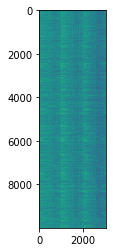

(10000, 3072)


In [10]:
#Print x_train
plt.imshow(x_train)
plt.show()
print(x_train.shape)

[[0.8509804  0.8352941  0.85490197 ... 0.8392157  0.8392157  0.84313726]
 [0.32941177 0.34117648 0.34509805 ... 0.32156864 0.31764707 0.31764707]
 [0.33333334 0.32941177 0.30980393 ... 0.4        0.42745098 0.30980393]
 ...
 [0.32941177 0.31764707 0.30980393 ... 0.8862745  0.8745098  0.8862745 ]
 [0.21960784 0.3019608  0.27058825 ... 0.67058825 0.654902   0.6627451 ]
 [0.2        0.32156864 0.38431373 ... 0.21568628 0.17254902 0.16470589]]


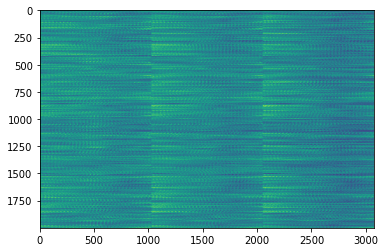

(2000, 3072)


In [37]:
print(x_test)
plt.imshow(x_test)
plt.show()
print(x_test.shape)

In [22]:
images = np.vstack([x_train])
classes = model.predict_classes(images, batch_size=10)
print("Predicted class is:",classes)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
Predicted class is: [6 6 6 ... 6 6 6]


In [27]:
activations = activation_model.predict(x_train) 
# Returns a list of five Numpy arrays: one array per layer activation

In [33]:
#Print activation shape
c1_activation = activations[1]
print("c1: "+str(c1_activation.shape))
c2_activation = activations[3]
print("c2: "+str(c2_activation.shape))
p1_activation = activations[2]
print("p1: "+str(p1_activation.shape))
p2_activation = activations[4]
print("p2: "+str(p2_activation.shape))

c1: (10000, 24, 24, 50)
c2: (10000, 8, 8, 60)
p1: (10000, 12, 12, 50)
p2: (10000, 4, 4, 60)


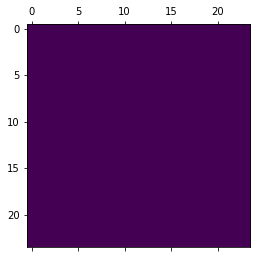

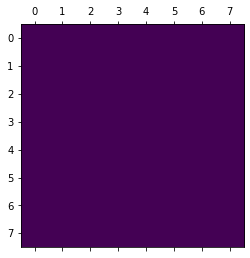

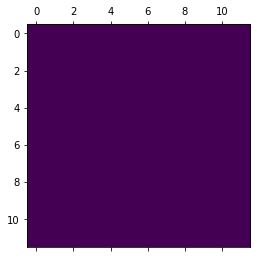

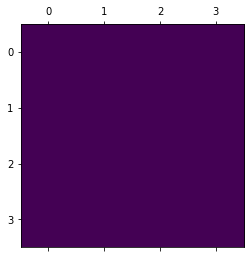

In [40]:
plt.matshow(c1_activation[0, :, :, 4], cmap='viridis')
plt.matshow(c2_activation[0, :, :, 4], cmap='viridis')
plt.matshow(p1_activation[0, :, :, 4], cmap='viridis')
plt.matshow(p2_activation[0, :, :, 4], cmap='viridis')

In [44]:
layer_names = []
for layer in model.layers[:12]:
    layer_names.append(layer.name) # Names of the layers, so you can have them as part of your plot

images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations): # Displays the feature maps
    n_features = layer_activation.shape[-1] # Number of features in the feature map
    size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
    n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    for col in range(n_cols): # Tiles each filter into a big horizontal grid
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, # Displays the grid
                         row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

MemoryError: Unable to allocate 824. GiB for an array with shape (1440000, 76800) and data type float64